<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/DenseDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ialhashim/DenseDepth.git

Cloning into 'DenseDepth'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 263 (delta 8), reused 15 (delta 4), pack-reused 242
Receiving objects: 100% (263/263), 12.13 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5 -O ./DenseDepth/kitti.h5

--2021-05-09 09:22:13--  https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.28.67
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.28.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897384 (165M) [application/x-www-form-urlencoded]
Saving to: ‘./DenseDepth/kitti.h5’

./DenseDepth/kitti. 100%[===================>] 164.89M  27.9MB/s    in 6.5s    

2021-05-09 09:22:20 (25.4 MB/s) - ‘./DenseDepth/kitti.h5’ saved [172897384/172897384]



In [3]:
cd DenseDepth/


/content/DenseDepth


In [4]:
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, display_images
from matplotlib import pyplot as plt
import keras

In [5]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
model = load_model('kitti.h5', custom_objects=custom_objects, compile=False)

In [6]:
model.layers[-3].get_weights()[0].shape

(3, 3, 104, 104)

(352, 1216, 3)

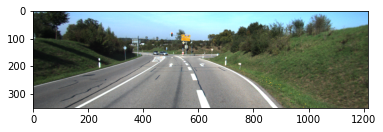

In [7]:
import PIL.Image as pil
import matplotlib.pyplot as plt
import numpy as np

img=pil.open('../rgb.png',mode='r')
img=np.asarray(img,dtype=float)/255.0
#img=np.clip(np.asarray(pil.open('../rgb.png'), dtype=float) / 255, 0, 1)

plt.imshow(img)
img.shape

In [8]:
from utils import predict, load_images, display_images

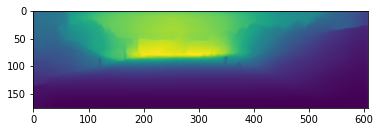

In [11]:

outputs = predict(model,img)

rescaled = outputs[0][:,:,0]
rescaled1=rescaled
plt.imshow(rescaled1)
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
plasma = plt.get_cmap('plasma')
pp=plasma(rescaled)[:,:,:3]

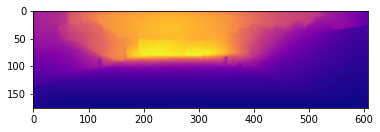

In [12]:
plt.imshow(pp,cmap='plasma')

In [ ]:
!python3 test.py 


Loading model...

Model loaded (kitti.h5).

Loaded (1) images of size (352, 1216, 3).
<Figure size 640x480 with 1 Axes>
<Figure size 1000x500 with 1 Axes>


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.480145 to fit



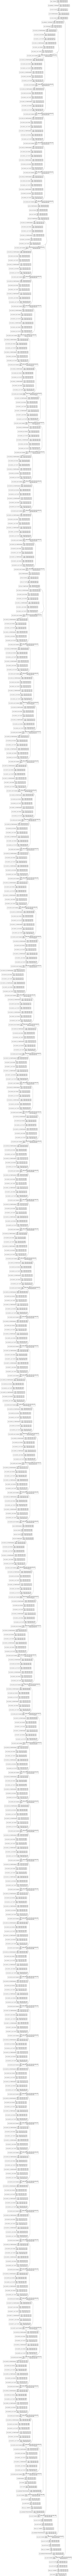

In [ ]:
model.build((352,1216,3))
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    
)

In [ ]:
#model.layers[].summary()
model1.layers[0].summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
model (Functional)           [(None, None, None, 1664) 12642880  
Total params: 12,642,880
Trainable params: 12,484,480
Non-trainable params: 158,400
_________________________________________________________________


In [155]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate
from tensorflow.keras import Model


import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import DenseNet169

class UpscaleBlock(Model):
    def __init__(self, filters, name):      
        super(UpscaleBlock, self).__init__()
        self.up = UpSampling2D(size=(2, 2), interpolation='bilinear', name=name+'_upsampling2d')
        self.concat = Concatenate(name=name+'_concat') # Skip connection        
        self.convA = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')
        self.reluA = LeakyReLU(alpha=0.2)
        self.convB = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')
        self.reluB = LeakyReLU(alpha=0.2)
    
    def call(self, x):        
        b = self.reluB( self.convB( self.reluA( self.convA( self.concat( [self.up(x[0]), x[1]] ) ) ) ) )
        return b 

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    return Model(x=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    return Model(x=[x], outputs=self.call(x))


class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()                
        self.base_model = DenseNet169(input_shape=(None, None, 3), include_top=False)   
        print('Base model loaded {}'.format(DenseNet169.__name__))
        
        # Create encoder model that produce final features along with multiple intermediate features
        outputs = [self.base_model.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu'] : outputs.append( self.base_model.get_layer(name).output )        
        self.encoder = Model(inputs=self.base_model.inputs, outputs=outputs)
        
    def call(self, x):

        return self.encoder(x)

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    #return Model(inputs=[x], outputs=self.call(x))
    #    return Model(x=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    #return Model(inputs=[x], outputs=self.call(x))
    #    return Model(x=[x], outputs=self.call(x))


class Decoder(Model):
    def __init__(self, decode_filters):
        super(Decoder, self).__init__()        
        self.conv2 =  Conv2D(filters=decode_filters, kernel_size=1, padding='same', name='conv2')        
        self.up1 = UpscaleBlock(filters=decode_filters//2,  name='up1')
        self.up2 = UpscaleBlock(filters=decode_filters//4,  name='up2')
        self.up3 = UpscaleBlock(filters=decode_filters//8,  name='up3')
        self.up4 = UpscaleBlock(filters=decode_filters//16, name='up4')        
        self.conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')       
        

    def call(self, features):        
        x, pool1, pool2, pool3, conv1 = features[0], features[1], features[2], features[3], features[4]
        up0 = self.conv2(x)        
        up1 = self.up1([up0, pool3])        
        up2 = self.up2([up1, pool2])        
        up3 = self.up3([up2, pool1])        
        up4 = self.up4([up3, conv1])        
        up4=self.conv3( up4 )
        return ReLU(max_value = 1.0)(up4)

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    return Model(features=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    return Model(features=[x], outputs=self.call(x))
    
class DepthEstimate(Model):
    def __init__(self):
        super(DepthEstimate, self).__init__()
        self.encoder = Encoder()
        print( int(self.encoder.layers[-1].output[0].shape[-1]  ))
        self.decoder = Decoder( decode_filters = int(self.encoder.layers[-1].output[0].shape[-1]  ) )
        self.inc_size=tf.keras.layers.UpSampling2D( size=(2, 2), data_format=None, interpolation='bilinear')

        print('\nModel created.')

    def call(self, x):
        return self.inc_size(self.decoder( self.encoder(x) ))

    def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))
        
    
    def build_graph(self):
       x = Input(shape = (352, 1216, 3))
       return Model(inputs=[x], outputs=self.call(x))

Base model loaded DenseNet169
1664

Model created.
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
encoder_27 (Encoder)            [(None, 11, 38, 1664 12642880    input_58[0][0]                   
__________________________________________________________________________________________________
decoder_27 (Decoder)            (None, 176, 608, 1)  30173209    encoder_27[0][0]                 
                                                                 encoder_27[0][1]                 
                                                                 encoder_27[0][2]                 
                                        

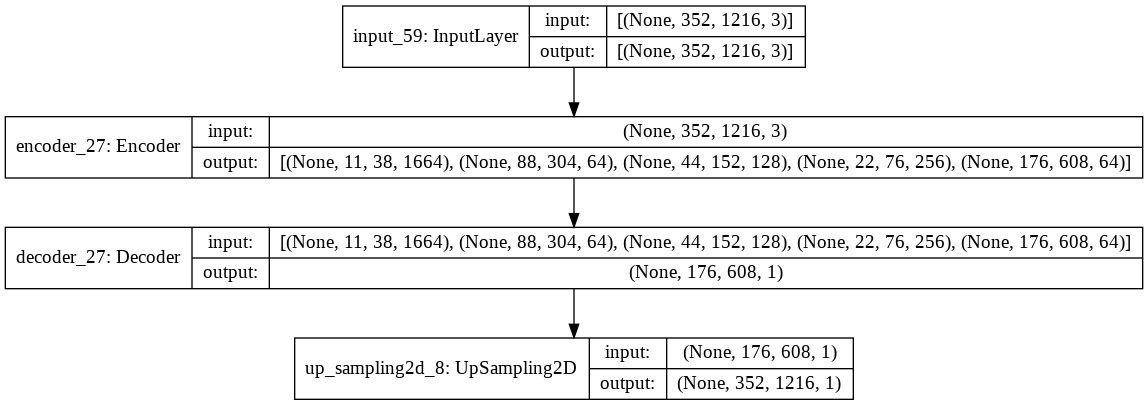

In [156]:
model1=DepthEstimate()


model1.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model1.build_graph(), to_file=dot_img_file, show_shapes=True,expand_nested=True)


In [82]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
model.layers[]

In [193]:
def get_weights_model(n):
  weight=model.layers[n].get_weights()
  if len(weight)==2:
    a=model.layers[n].get_weights()[0]
    b=model.layers[n].get_weights()[1]
    print(a.shape)
    print(b.shape)
    print(model.layers[n])
    return [a,b]
  else:
    print(model.layers[n])
    print(weight[0].shape)
    return weight[0]

In [255]:
w=get_weights_model(614)

(3, 3, 104, 104)
(104,)


In [208]:
model1.layers[1].layers[-1].set_weights(w)#[0].shape

In [180]:
len(model1.layers[0].layers[1].layers)#[:].get_weights()

595

In [256]:
model1.layers[1].layers[4].layers[4].set_weights(w)

In [252]:
model.layers[613:]

In [188]:
def set_den():
  
  for i in range(0,594):
    model1.layers[0].layers[1].layers[i].set_weights(model.layers[i].get_weights())
    #print(model.layers[i].get_weights()
set_den()

In [23]:
model1.summary()

Model: "depth_estimate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  12642880  
_________________________________________________________________
decoder (Decoder)            multiple                  30173209  
Total params: 42,816,089
Trainable params: 42,657,689
Non-trainable params: 158,400
_________________________________________________________________


In [187]:
model1.layers[0].layers[1].layers[2].get_weights()

[array([[[[-9.07550287e-03, -1.23990690e-02,  1.07400268e-02, ...,
           -7.68918544e-03, -1.10798482e-07, -9.28494707e-02],
          [-3.09768301e-02, -2.37936024e-02, -2.58349720e-02, ...,
           -1.22429002e-02, -9.80032269e-08,  8.31141099e-02],
          [-4.16693836e-02, -8.20024963e-03,  1.69866662e-02, ...,
           -9.74439899e-05, -1.45668295e-07,  8.82903580e-03]],
 
         [[ 4.41965833e-02, -4.22134250e-03, -1.24678370e-02, ...,
            1.05650863e-02, -1.92836715e-08, -1.39920339e-02],
          [ 4.63942885e-02, -3.50625142e-02, -4.51328903e-02, ...,
            1.61913279e-02,  3.97498034e-08,  1.50387753e-02],
          [ 3.73947024e-02, -1.57523286e-02, -7.69552775e-03, ...,
            2.60037370e-02,  1.39279459e-08, -3.47095798e-03]],
 
         [[-4.49855104e-02,  6.33901805e-02, -2.75472403e-02, ...,
           -3.70845869e-02, -3.17272608e-08, -5.88625111e-03],
          [-6.41272590e-02,  7.44198561e-02, -3.62181328e-02, ...,
           -5.886

In [189]:
model1.layers[0].layers[1].layers[2].get_weights()

[array([[[[-1.13617079e-02, -9.68709588e-03,  8.94749723e-03, ...,
           -8.73601343e-03, -1.10798482e-07, -8.43976215e-02],
          [-2.71677803e-02, -1.55195622e-02, -2.98576858e-02, ...,
           -7.90739525e-03, -9.80032269e-08,  9.03173313e-02],
          [-3.09623182e-02, -5.94166573e-03,  1.30693316e-02, ...,
            2.86741019e-03, -1.45668295e-07,  1.29339024e-02]],
 
         [[ 3.93887274e-02, -3.59917711e-03, -1.65213253e-02, ...,
            6.28154632e-03, -1.92836715e-08, -6.81190239e-03],
          [ 4.90357392e-02, -2.98250131e-02, -5.06463163e-02, ...,
            1.83816310e-02,  3.97498034e-08,  2.04915293e-02],
          [ 4.48244475e-02, -1.37950396e-02, -1.17260255e-02, ...,
            2.68799849e-02,  1.39279459e-08, -6.40441256e-04]],
 
         [[-5.10168150e-02,  6.67447150e-02, -3.43579389e-02, ...,
           -4.14108783e-02, -3.17272608e-08,  3.28264642e-03],
          [-6.02720454e-02,  7.78620988e-02, -4.54904512e-02, ...,
           -5.823

In [258]:
model1.save_weights('/content/drive/MyDrive/nets/modified_t_net/weights/')

In [259]:
model1.save('/content/drive/MyDrive/nets/modified_t_net/')

ValueError: ignored

In [260]:
model1.load_weights('/content/drive/MyDrive/nets/modified_t_net/weights/')